In [3]:
import os
import numpy as np
import pandas as pd

import pmdarima as pm
from arch import arch_model
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [4]:
print(os.getcwd())

today = datetime.today().strftime("%Y-%m-%d")
fname = f"2000-01-01_{today}_dax_returns.csv"

# Load data
ret_df = pd.read_csv(f"./data/{fname}", index_col=0)
ret_df.index = pd.to_datetime(ret_df.index)
ret_df.head()

c:\Users\ytl_c\OneDrive\Desktop\23_24 WS (Master)\PTSFC\2023_11-PTSFC


,ret1,ret2,ret3,ret4,ret5
2000-01-10,2.109446,6.727690,6.309258,5.012269,2.555809
2000-01-11,-0.496065,1.613381,6.231625,5.813193,4.516204
2000-01-12,0.312373,-0.183692,1.925754,6.543998,6.125566
2000-01-13,0.622550,0.934923,0.438858,2.548304,7.166548
2000-01-14,3.075296,3.697846,4.010219,3.514153,5.623600


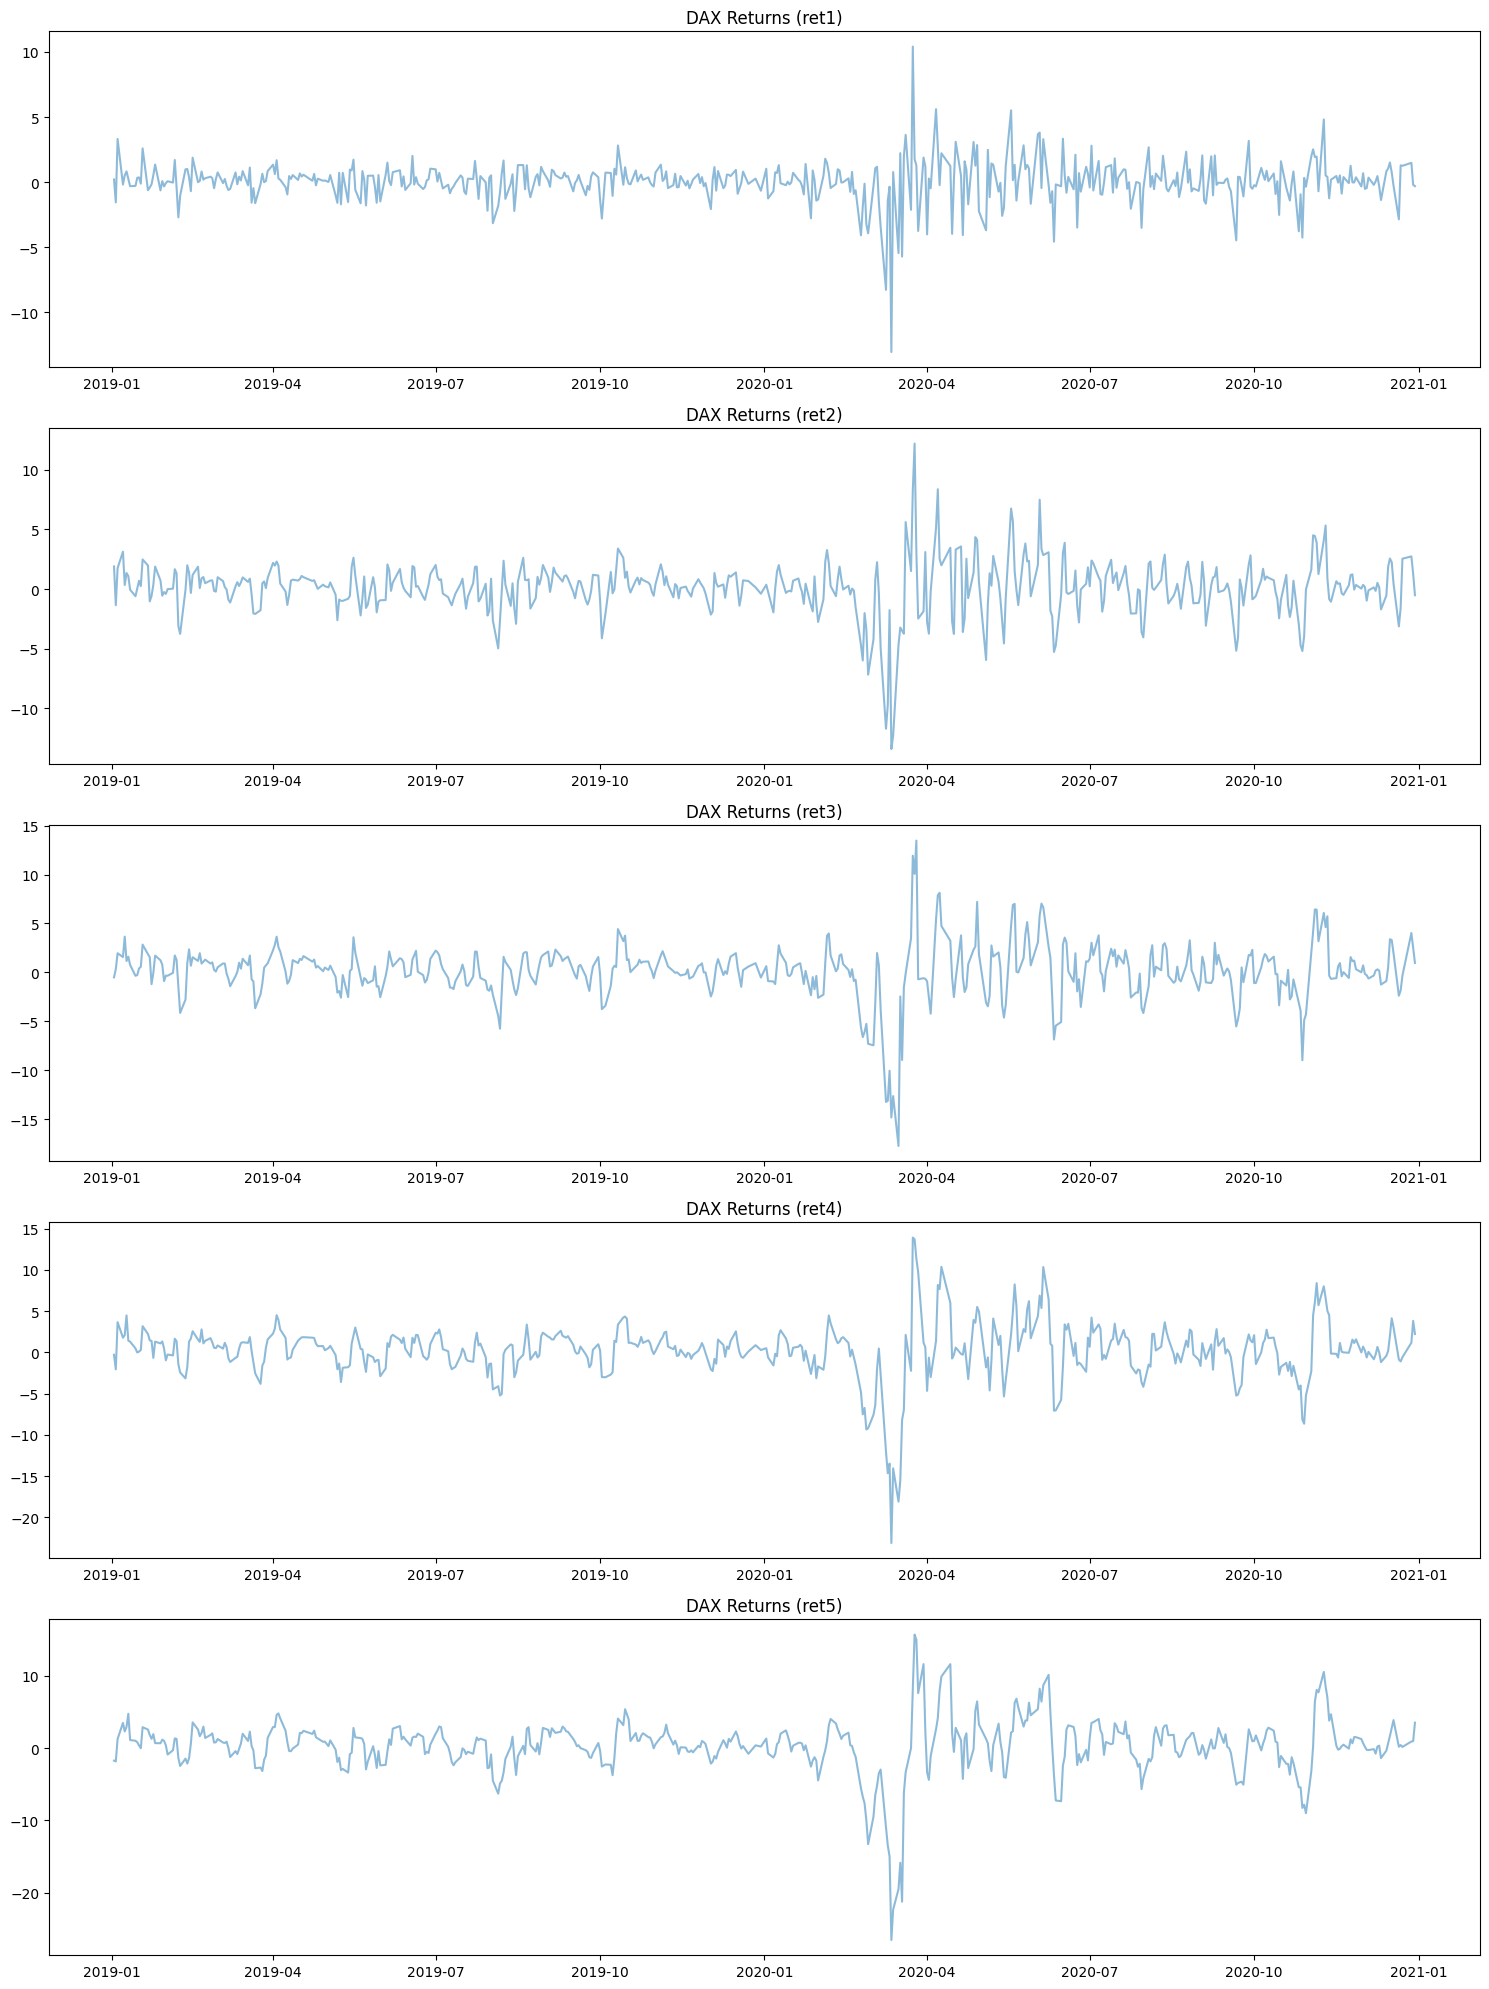

In [5]:
start_yr = 2019
end_yr = 2020
filtered_df = ret_df[(ret_df.index.year >= start_yr) & (ret_df.index.year <= end_yr)]

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 20))

for i, horizon in enumerate(filtered_df.columns):
    axes[i].plot(filtered_df[horizon], alpha=0.5)
    axes[i].set_title(f"DAX Returns ({horizon})")

plt.tight_layout()
plt.show()

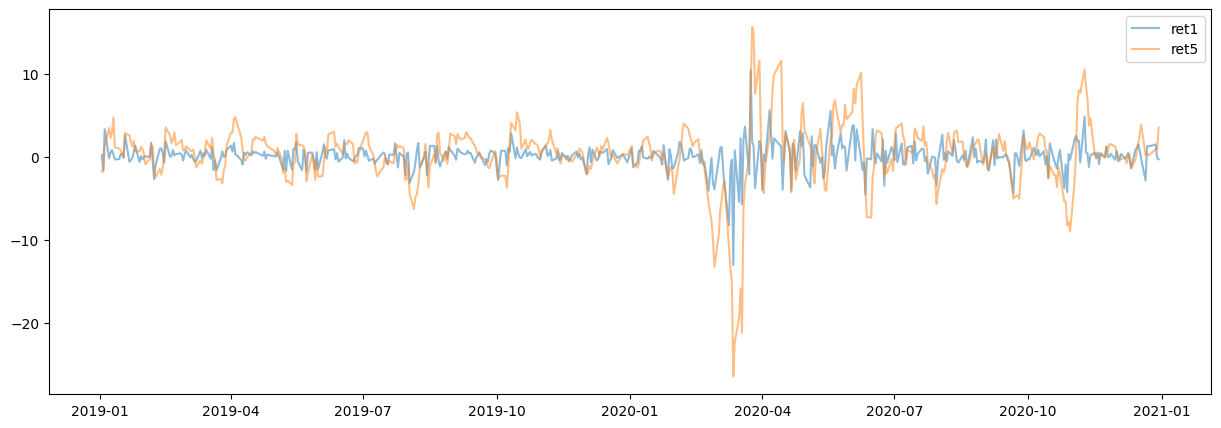

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(filtered_df['ret1'], alpha=0.5, label='ret1')
plt.plot(filtered_df['ret5'], alpha=0.5, label='ret5')
plt.legend()
plt.show()

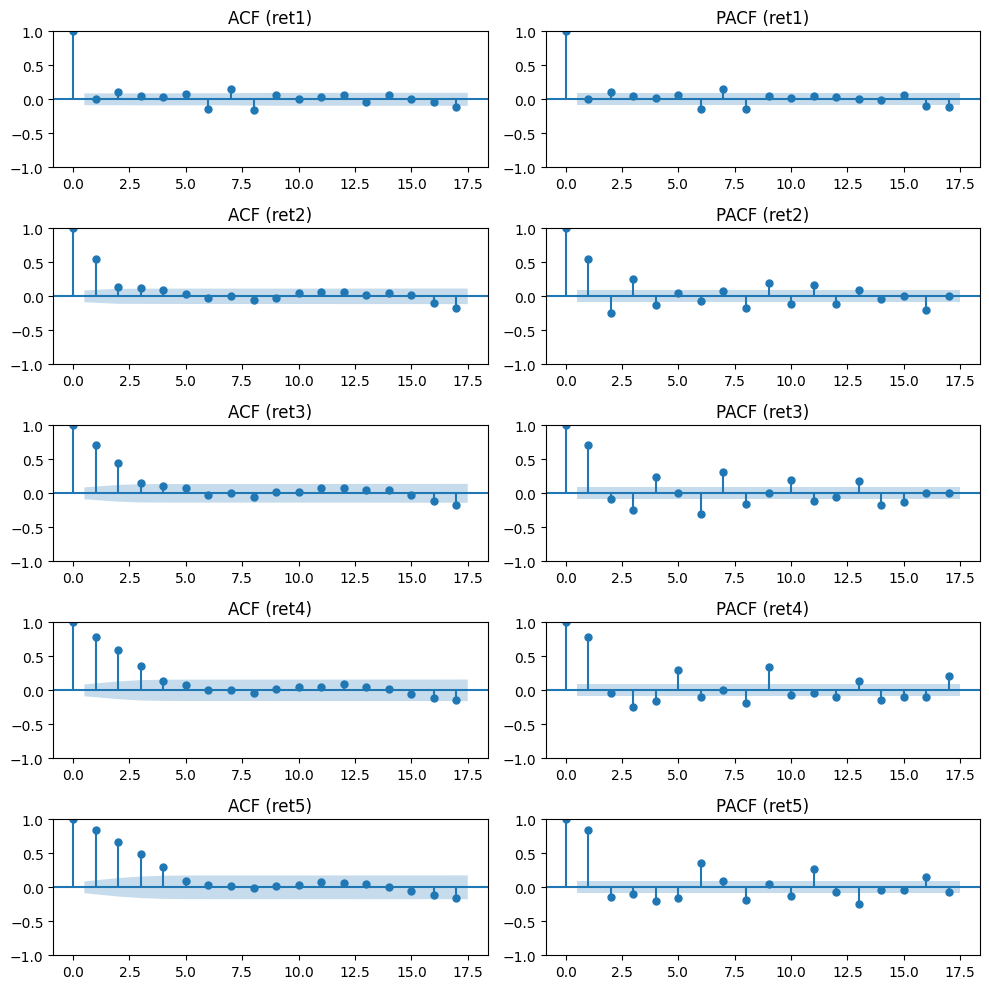

In [28]:
fig, axes = plt.subplots(5, 2 ,figsize=(10,10))

max_lag = 17
for i, horizon in enumerate(filtered_df.columns):
    plot_acf(filtered_df[horizon], lags=max_lag, ax=axes[i, 0], title=f"ACF ({horizon})")
    plot_pacf(filtered_df[horizon], lags=max_lag, ax=axes[i, 1], title=f"PACF ({horizon})")

plt.tight_layout()
plt.show()

In [18]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# Tests for absence of autocorrelation *WITHIN* k lags
# H0 = no autocorrelation
# p value low -> reject H0 -> probably some autocorrelation
# p value high -> cannot reject H0 -> probably no autocorrelation

# eg for ret1
# p values are quite high at low lags -> probably no autocorrelation
# as lags increase to 20, because we are testing the H0 of all autocorr simultaneously being = 0
# p values drop -> cannot reject that all of them are simultaneously = 0

# eg for ret5
# p value is already very small at lag=1 at 10^-80 -> reject H0 -> probably some autocorrelation
# it further decreases till lag=5 to 10^-150 -> probably some autocorrelation
# but up to lag=20 it remains at the order of 10^-150
# so the addition of more lags does not make the test reject more strongly, 
# meaning that the main component of autocorrelation is probably already captured by the first 5 lags

for i, horizon in enumerate(filtered_df.columns):

    # Perform Ljung-Box test against white noise
    lb_test = acorr_ljungbox(filtered_df[horizon], lags=[1, 2, 3, 4, 5, 20], return_df=True)

    # return max pval
    print(f"Ljung-Box test results for {horizon}:")
    print(lb_test)
    print('- '*15)


Ljung-Box test results for ret1:
      lb_stat     lb_pvalue
1    0.000430  9.834648e-01
2    5.754243  5.629657e-02
3    6.822119  7.778883e-02
4    7.434877  1.146155e-01
5   10.599133  5.993348e-02
20  66.721588  6.188412e-07
- - - - - - - - - - - - - - - 
Ljung-Box test results for ret2:
       lb_stat     lb_pvalue
1   154.744610  1.592226e-35
2   163.424991  3.256223e-36
3   170.558240  9.641606e-37
4   175.377164  7.331626e-37
5   175.781881  4.257161e-36
20  213.729321  2.122368e-34
- - - - - - - - - - - - - - - 
Ljung-Box test results for ret3:
       lb_stat     lb_pvalue
1   252.118373  8.966501e-57
2   355.534659  6.260798e-78
3   368.109121  1.787407e-79
4   373.245388  1.675248e-79
5   375.971555  4.465050e-79
20  424.346879  1.792390e-77
- - - - - - - - - - - - - - - 
Ljung-Box test results for ret4:
       lb_stat      lb_pvalue
1   312.776935   5.423712e-70
2   495.296143  2.804201e-108
3   561.593917  2.132322e-121
4   570.817030  3.203633e-122
5   574.070342  8.08617

In [22]:
# do fits for all ret1 to ret5 and save the models in a dict
models = {}

for horizon in filtered_df.columns:

    print('= '*15)
    print(f"start {horizon}")
    print('= '*15)
    models[horizon] = pm.auto_arima(ret_df[horizon], start_p=1, start_q=1,
                                    max_p=3, max_q=3, trace=True,
                                    error_action='ignore',
                                    suppress_warnings=True,
                                    stepwise=True)

# The stepwise approach follows the strategy laid out by Hyndman and Khandakar in their 2008 paper,
# “Automatic Time Series Forecasting: The forecast Package for R”.

= = = = = = = = = = = = = = = 
start ret1
= = = = = = = = = = = = = = = 
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=21739.717, Time=0.88 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=21738.805, Time=0.24 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=21739.067, Time=0.50 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=21739.037, Time=0.40 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=21737.417, Time=0.11 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 2.135 seconds
= = = = = = = = = = = = = = = 
start ret2
= = = = = = = = = = = = = = = 
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.60 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=25852.809, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=24210.088, Time=0.37 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.49 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=25852.100, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept